# Cookie Cats Mobile Game A/B test

### Scenario

This analysis rests on Cookie Cats mobile game data, which captures the A/B test results of the game to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. 

### Contents of the data

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

`userid`: A unique number that identifies each player.
`version`: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
`sum_gamerounds`: the number of game rounds played by the player during the first 14 days after install.
`retention_1`: Did the player come back and play 1 day after installing?
`retention_7`: Did the player come back and play 7 days after installing?

### Goal

While conducting this test, we aim to answer, if the gate switch from level 30 to level 40 influences the short-term and mid-term retention of the user.

### Metrics

__Invariants__: `sum_gamerounds`. In our experiment, we disregard the gamerounds played, but we use this metric in EDA stage to better understand the distribution and remove the outliers, which might suggest some automation rather than manual user inputs. 

__Unit of diversion__: `userid` as observations are grouped by unique id assigned to each user.

__Unit of analysis__: proportion of `retention_1` and `retention_7` in control and experiment groups.


### Assumptions

We treat those who were assigned to `gate_30` as control population, as per the context definition, stating that players were moved to `gate_40`, indicating it beign an experiment group. 

### Outline of the analysis

1. Data cleaning and exploratory data analysis to design the A/B experiment
2. Calculations and A/B experiment
3. Decision and recommendations
4. Alternative approaches

### Note

This analysis is supplemented by additional Google Looker dashboard which can be accessed [here](https://lookerstudio.google.com/reporting/7fea9091-297c-4bc8-8ef0-75dae170b949).


## 01 Data cleaning and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import scipy.stats as stats

In [2]:
game_data = pd.read_csv('datasets/cookie_cats.csv')
game_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
print(f'The observations of the dataframe: {game_data.shape[0]}')
print(f'The features of the dataframe: {game_data.shape[1]}')
print('\n')
print('::: Dataframe features overview :::')
print('\n')
game_data.info()


The observations of the dataframe: 90189
The features of the dataframe: 5


::: Dataframe features overview :::


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
print(f'::: Gamerounds summary :::')
print('\n')
game_data['sum_gamerounds'].describe()

::: Gamerounds summary :::




count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [5]:
print('The NaN, Null values in features:')
game_data.isna().sum()

The NaN, Null values in features:


userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [6]:
print('Number of duplicate users:')
game_data['userid'].duplicated().sum()

Number of duplicate users:


np.int64(0)

### First observations:

- There are no `userid` duplicates, indicating that dataset is consistent and captures the behaviour of each user only once;
- There are no `NaN` cells in any feature column;
- However, the distribution of `sum_gamerounds` is suspicious, as the maximum values greatly exceed the median. When we plot it, we see that distribution is largely skewed. Those large numbers might be generated by automated bots or system tests, so we shouldn't include them in our analysis, as they will bias our data. 

We proceed with removing outliers in `sum_gamerounds` feature. We support our doubts by first plotting the distribution, which is exponential and ends in unrealistic long-tail at the higher value range – it's impossible to clock 50k sessions manually. 

Next step is also to filter out the observations that had at least one session and remove entries with zero `sum_gameround`to assume the user is active.

(0.0, 2000.0)

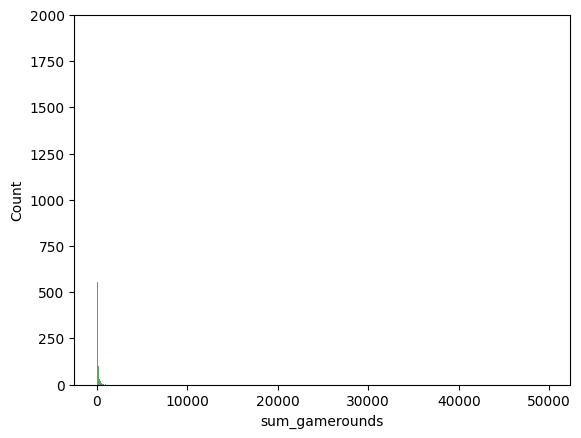

In [7]:
plt.figure()
sns.histplot(data=game_data, x='sum_gamerounds', color='forestgreen')
plt.ylim(0, 2000)

In [8]:
def outlier_detection(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Looks for outliers in a specified column
    using IQR method and removes observations from dataframe
    Args: 
      df (pd.DataFrame): original dataframe
      col (str): column name in the dataframe
    Returns:
      pd.DataFrame: cleaned dataframe 
    """
    first_q = np.percentile(df[col], 25)
    third_q = np.percentile(df[col], 75)
    IQR = third_q - first_q
    lower = first_q - 1.5 * IQR
    upper = third_q + 1.5 * IQR
    updated_df = df[(df[col] > lower) & 
          (df[col] < upper)]
    return updated_df

In [9]:
game_data_no_outliers = outlier_detection(game_data, 'sum_gamerounds')

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

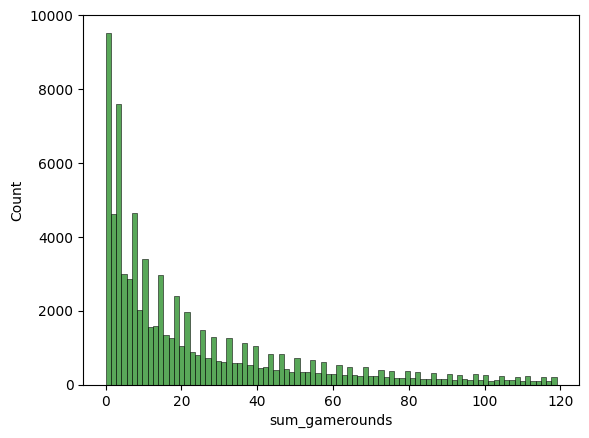

In [10]:
plt.figure()
sns.histplot(data=game_data_no_outliers, x='sum_gamerounds', color='forestgreen')

In [11]:
game_data = game_data_no_outliers[(game_data_no_outliers['sum_gamerounds'] > 0)]

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

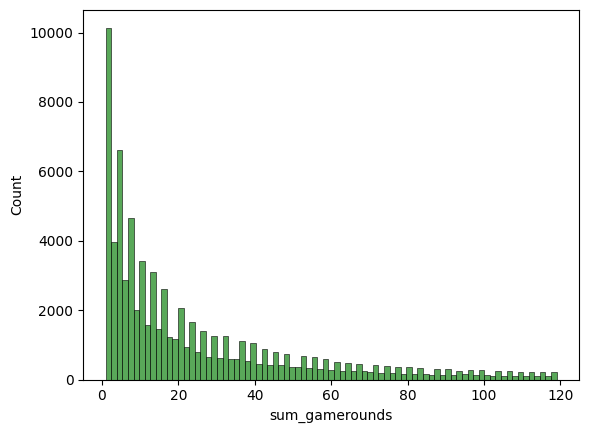

In [12]:
plt.figure()
sns.histplot(data=game_data, x='sum_gamerounds', color='forestgreen')

Text(0.5, 58.7222222222222, 'Sum gamerounds')

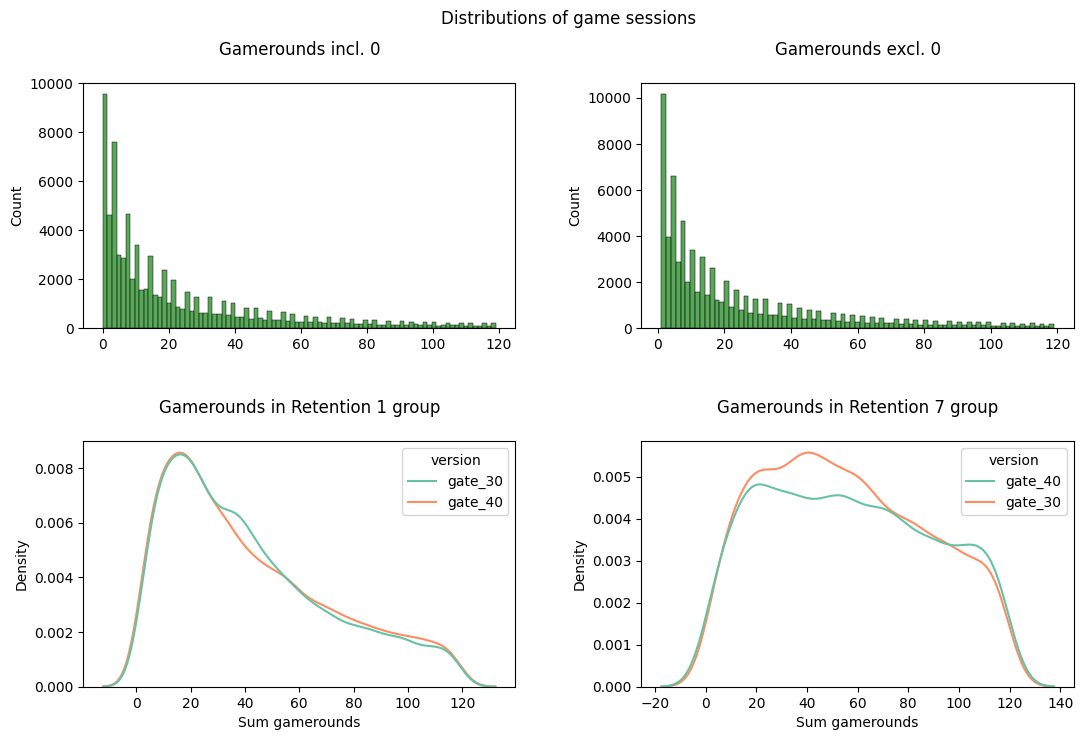

In [14]:
retention_1_temp = game_data[(game_data['retention_1'] == True)]
retention_7_temp = game_data[(game_data['retention_7'] == True)]

fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.tight_layout(pad=6)


fig.suptitle('Distributions of game sessions')
sns.histplot(data=game_data_no_outliers, x='sum_gamerounds', ax=axs[0, 0], color='forestgreen')
axs[0, 0].set_title('Gamerounds incl. 0', pad=20)
axs[0, 0].set_xlabel('')
sns.histplot(data=game_data, x='sum_gamerounds', ax=axs[0, 1], color='forestgreen')
axs[0, 1].set_title('Gamerounds excl. 0', pad=20)
axs[0, 1].set_xlabel('')
sns.kdeplot(data=retention_1_temp, x='sum_gamerounds', ax=axs[1, 0], hue='version')
axs[1, 0].set_title('Gamerounds in Retention 1 group', pad=20)
axs[1, 0].set_xlabel('Sum gamerounds')
sns.kdeplot(data=retention_7_temp, x='sum_gamerounds', ax=axs[1, 1], hue='version')
axs[1, 1].set_title('Gamerounds in Retention 7 group', pad=20)
axs[1, 1].set_xlabel('Sum gamerounds')

## Summary

After cleaning the data, we arrive at some conclusions and assumptions for the next steps in our hypothesis testing:

- The original dataset included outliers with sessions up to 50K, which do not represent actual users, and we have removed those;
- We also removed all observations with zero sessions, as we want to analyze active users who played the game at least once;
- We also see that over the time, number of sessions approach the uniform distribution, as gameround sum in overall, Retention 1 and Retention 7 groups show;
- Also, we see that in those who kept playing after 7 day period, the gameround count is (at least, visually) higher with our gate_30 group.


After the initial data cleaning and observation, we aim to proceed with two A/B test questions. They both rest on the same set of assumptions, but only measure the immediate effect of the change, and an effect observed in one-week period:

1. Does the gate-level increase influences the first-day retention?
2. Does the gate-level increase influences the seven-day retention?

__Note:__ we initially opted to calculate only the `retention_7` proportion from the `retention_1` subset, assuming that first-day retention is `True` for every `True` in `retention_7`. However, the sanity check returned observations that were `False` for first-day, but `True` for a week, comprising those users that didn't come back to game the next day, but played it some time over the week period. 

Given this, we selected full dataset as our baseline, and conducted experiments on `retention_1` and `retention_7` groups separately, questioning the willingness to play in general.


### Forulating the A/B test requirements
 
1. Control group: gate_30
2. Experiment group: gate_40
3. Metric: proportion of `retention_1`; proportion of `retention_7`




## 02 Initial level influence on first-day retention

In the first part, we aim to analyze if there's a statistically significant difference of the first-day retention in groups that were either assigned level 30 or level 40 at the start of the game. 

### Null hypothesis

The intial level of the game does not influence the short-term playing habits (retention after one day), i.e. the proportion of `retention_1` in `gate_30` is the same as the proportion of `retention_1` in `gate_40`:

__p(30 | r1) = p(40 | r1)__

### Steps:

1. Random sampling. Using the [calculator](https://www.evanmiller.org/ab-testing/sample-size.html), we draw a random sample of observations from the populations – the full dataset;
2. To avoid sample ratio mismatch, we compare our control and experiment groups using chi-squared test;
3. If successful, we proceed with the statistical analysis of two proportions;
4. Calculating confidence intervals;
5. Decision on Null hypothesis


In [15]:
(game_data['retention_1'] == 1).sum() / len(game_data['retention_1'])

np.float64(0.4047735086078584)

We can expected our baseline conversion rate at 40%, with minimum detectable effect of 3%. These constants give us the __sample size of 4,199__ with significance level of 0.05 and statistical power of 80%.

In [16]:
retention_1_sample = pd.DataFrame.sample(game_data, 4199, random_state=1)

In [17]:
control_r1_prop = ((retention_1_sample['version'] == 'gate_30').sum() / len(retention_1_sample['version'])*100)
exp_r1_prop = ((retention_1_sample['version'] == 'gate_40').sum() / len(retention_1_sample['version'])*100)                             
print(control_r1_prop, exp_r1_prop)

stats.chisquare([control_r1_prop, exp_r1_prop], [50, 50])

49.869016432483924 50.130983567516076


Power_divergenceResult(statistic=np.float64(0.0006862677983695327), pvalue=np.float64(0.9791004372288336))

The evaluation of sample for sample ratio mismatch was completed using chi-squared test. The high p-value of 0.979 shows that there are no statistically significant differences between the sample proportion and expected 50:50 ratio. We have to accept the Null hypothesis indicating similarity and proceed further in our A/B test.

We first summarize the proportions of both control and experiment groups by their first-day retention in the contigency table. We then perform chi-squared contingency test to test if we can reject the null hypothesis.

In [18]:
retention_1_sample['retention_1'] = retention_1_sample['retention_1'].astype(int)
retention_1_sample['retention_7'] = retention_1_sample['retention_7'].astype(int)
ret1_contingency = pd.crosstab(retention_1_sample['retention_1'], retention_1_sample['version'])
ret1_contingency

version,gate_30,gate_40
retention_1,,
0,1241,1266
1,853,839


In [19]:
control_1 = ret1_contingency.iloc[1, 0]
control_t = ret1_contingency.iloc[0, 0] + ret1_contingency.iloc[1, 0]
exp_1 = ret1_contingency.iloc[1, 1]
exp_t = ret1_contingency.iloc[1, 0] + ret1_contingency.iloc[0, 1]

In [20]:
chi2_r1 = stats.chi2_contingency(ret1_contingency)
ci_control = sms.proportion_confint(control_1, control_t)
ci_experiment = sms.proportion_confint(exp_1, exp_t)

print(f'::: TEST SUMMARY :::')
print('\n')
print(f'Chi-squared statistic: {chi2_r1[0]}')
print(f'P-value: {chi2_r1[1]}')
print(f'Degrees of freedom: {chi2_r1[2]}')
print('\n')
print(f'Control group confidence interval bounds: {ci_control[0]}, {ci_control[1]}')
print(f'Experiment group confidence interval bounds: {ci_experiment[0]}, {ci_experiment[1]}')

::: TEST SUMMARY :::


Chi-squared statistic: 0.30082415758847336
P-value: 0.5833662087609891
Degrees of freedom: 1


Control group confidence interval bounds: 0.38630960978286377, 0.42839908171665864
Experiment group confidence interval bounds: 0.37511875406743606, 0.4167642095946687


/var/folders/7j/0j88jv2s5njcjv6hwgj4j51w0000gn/T/ipykernel_13504/2436547068.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(['Experiment', 'Control'])


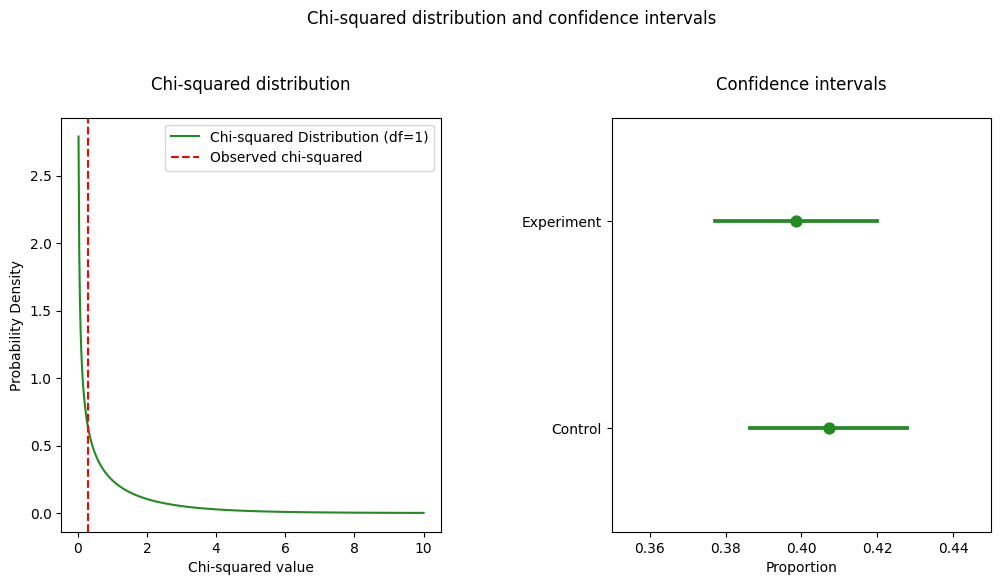

In [21]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Chi-squared distribution and confidence intervals')
fig.set_figheight(6)
fig.set_figwidth(12)
fig.subplots_adjust(top=0.8, wspace=0.45)

x = np.linspace(0, 10, 500)
y = stats.chi2.pdf(x, chi2_r1[2])
sns.lineplot(x=x, y=y, label="Chi-squared Distribution (df=1)", ax=axs[0], color='forestgreen')
axs[0].axvline(x=chi2_r1[0], color='red', linestyle='--', label=f"Observed chi-squared")
axs[0].set_title('Chi-squared distribution', pad=20)
axs[0].set_xlabel('Chi-squared value')
axs[0].set_ylabel('Probability Density')
axs[0].legend()

sns.pointplot(data=retention_1_sample, x='retention_1', y='version', ax=axs[1], color='forestgreen', linestyle="none")
axs[1].set_title('Confidence intervals', pad=20)
axs[1].set_xlabel('Proportion')
axs[1].set_yticklabels(['Experiment', 'Control'])
axs[1].set_xlim(0.35, 0.45)
axs[1].set_ylabel('');

With p-value of 0.58 we fail to reject the Null hypothesis, indicating that differences in control and experiment groups are not significant. The test, performed by the [calculator](https://www.evanmiller.org/ab-testing/chi-squared.html#!853/1241;839/1266@95) return the p-value of 0.19, but the outcome is similar: we fail to reject the Null. This is further reinforced by the overlapping of confidence intervals.

This means that raising the entry level from 30 to 40 does not influence the day 1 retention. What about the first week?

## 03 Initial level influence on seven-day retention

In the second part of the experiment, we aim to analyze the seven-day retention, based on the initial game level. Currently, we couldn't conclude it there was any influence for the retention after the first day. We will use the same sample of observations for our analysis, and will use the corresponding methods. 

### Null hypothesis

The intial level of the game does not influence the mid-term playing habits (retention after one week), i.e. the proportion of `retention_7` in `gate_30` is the same as the proportion of `retention_7` in `gate_40`:

__p(30 | r7) = p(40 | r7)__

### Steps:

1. We use the same sample we have drawn previously, thus the sample ratio mismatch test results still stands, and we can proceed with analysis;
3. Analyzing two proportions;
4. Calculating confidence intervals;
5. Decision on Null hypothesis


In [22]:
retention_1_sample['retention_7'] = retention_1_sample['retention_7'].astype(int)
ret7_contingency = pd.crosstab(retention_1_sample['retention_7'], retention_1_sample['version'])
ret7_contingency

version,gate_30,gate_40
retention_7,,
0,1826,1857
1,268,248


In [23]:
control_7 = ret7_contingency.iloc[1, 0]
control_t7 = ret7_contingency.iloc[0, 0] + ret7_contingency.iloc[1, 0]
exp_7 = ret7_contingency.iloc[1, 1]
exp_7t = ret7_contingency.iloc[1, 0] + ret7_contingency.iloc[0, 1]

In [24]:
chi2_r7 = stats.chi2_contingency(ret7_contingency)
ci_control_7 = sms.proportion_confint(control_7, control_t7)
ci_experiment_7 = sms.proportion_confint(exp_7, exp_7t)

print(f'::: TEST SUMMARY :::')
print('\n')
print(f'Chi-squared statistic: {chi2_r7[0]}')
print(f'P-value: {chi2_r7[1]}')
print(f'Degrees of freedom: {chi2_r7[2]}')
print('\n')
print(f'Control group confidence interval bounds: {ci_control_7[0]}, {ci_control_7[1]}')
print(f'Experiment group confidence interval bounds: {ci_experiment_7[0]}, {ci_experiment_7[1]}')

::: TEST SUMMARY :::


Chi-squared statistic: 0.9151683047260022
P-value: 0.33874682402574374
Degrees of freedom: 1


Control group confidence interval bounds: 0.1136759958261542, 0.14229344065904162
Experiment group confidence interval bounds: 0.10305478178376716, 0.13035698292211517


/var/folders/7j/0j88jv2s5njcjv6hwgj4j51w0000gn/T/ipykernel_13504/795205115.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(['Gate 40', 'Gate 30'])


(0.09, 0.15)

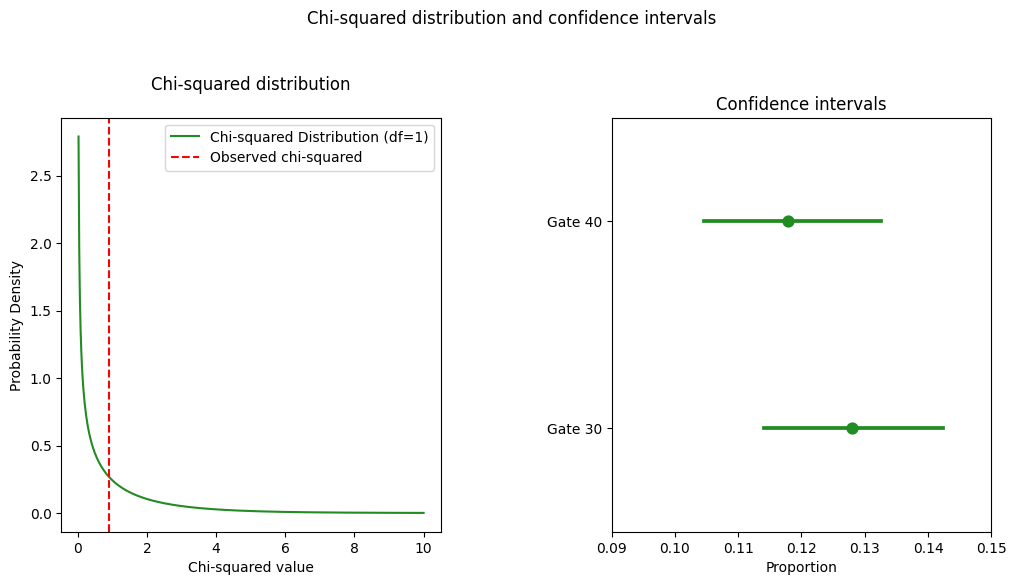

In [25]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Chi-squared distribution and confidence intervals')
fig.set_figheight(6)
fig.set_figwidth(12)
fig.subplots_adjust(top=0.8, wspace=0.45)

x = np.linspace(0, 10, 500)
y = stats.chi2.pdf(x, chi2_r7[2])
sns.lineplot(x=x, y=y, label="Chi-squared Distribution (df=1)", ax=axs[0], color='forestgreen')
axs[0].axvline(x=chi2_r7[0], color='red', linestyle='--', label=f"Observed chi-squared")
axs[0].set_title('Chi-squared distribution', pad=20)
axs[0].set_xlabel('Chi-squared value')
axs[0].set_ylabel('Probability Density')
axs[0].legend()

sns.pointplot(data=retention_1_sample, x='retention_7', y='version', ax=axs[1], color='forestgreen', linestyle="none")
axs[1].set_title("Confidence intervals")
axs[1].set_yticklabels(['Gate 40', 'Gate 30'])
axs[1].set_ylabel('')
axs[1].set_xlabel('Proportion')
axs[1].set_xlim(0.09, 0.15)

With p-value of 0.338 we fail to reject the Null hypothesis, indicating that differences in control and experiment groups are not significant. The test, performed by the [calculator](https://www.evanmiller.org/ab-testing/chi-squared.html#!268/1826;248/1857@95) return the p-value of 0.25, but the outcome is similar: we fail to reject the Null. This is further reinforced by the overlapping of confidence intervals.

This means that raising the entry level from 30 to 40 does not influence the day 7 retention.

## 04 Summary

During this A/B test, we failed to detect, if there was a significant difference between control group (level 30) and experiment group (level 40). We sampled 4199 obervations from the full dataset, and using chi-squared test checked for sample ratio mismatch. However, in both retention after the first day and retention after 7th day experiments, experiment groups didn't differ, and we we unsucessful in rejecting the Null.

### Increasing the gate level does not influence one-day and one-week retention.

## Appendix: increasing initial difficulty influences the frequency of play

Even though the retention was not influenced by initial game level, our EDA indicated that in retention_7 group, the average gameround sum might be different. In this short appendix, we run a quick t-test on independent samples:

- Metric: `sum_gamerounds`
- Unit of diversion: `userid`
- Filter: by `retention_7` == `True`

In [31]:
gamerounds_sample = pd.DataFrame.sample(game_data, 4199, random_state=2)

In [32]:
gamerounds = gamerounds_sample.loc[(gamerounds_sample['retention_7'] == True)]
gamerounds = gamerounds[['version', 'sum_gamerounds']]

In [34]:
mu_control = gamerounds['sum_gamerounds'].loc[(gamerounds['version'] == 'gate_30')].mean()
mu_experiment = gamerounds['sum_gamerounds'].loc[(gamerounds['version'] == 'gate_40')].mean()
diff = mu_control - mu_experiment


print(f'Average gamerounds (control): {mu_control}')
print(f'Average gamerounds (experiment): {mu_experiment}')
print(f'The estimated average weekly sales difference: {diff}')

Average gamerounds (control): 56.330827067669176
Average gamerounds (experiment): 54.06167400881057
The estimated average weekly sales difference: 2.269153058858606


In [29]:
t = stats.ttest_ind(gamerounds['sum_gamerounds'].loc[(gamerounds['version'] == 'gate_30')], 
                    gamerounds['sum_gamerounds'].loc[(gamerounds['version'] == 'gate_40')])
t_stat_p1 = t[0]
p_val_p1 = t[1]
df_p1 = t.df
df_p1

print(f'The t-test results:')
print('\n')
print(f"T-test statistic: {t_stat_p1}")
print(f"P-value: {p_val_p1}")
print(f"Degrees of freedom: {df_p1}")

The t-test results:


T-test statistic: 0.7520211616866302
P-value: 0.4523986706387174
Degrees of freedom: 491.0


In [30]:
p1_t_ci = t.confidence_interval(confidence_level=0.95)

print(f"The difference confidence interval lower bound = {p1_t_ci[0]}")
print(f"The difference confidence interval upper bound = {p1_t_ci[1]}")

The difference confidence interval lower bound = -3.659467767724303
The difference confidence interval upper bound = 8.197773885441515


### Summary

With p-value = 0.452 and difference confidence interval including 0, we fail to conclude that there's significant differences in playing habits and retention. 

# Conclusions and directions for improvements

Our statistical tests failed to reject the Null hypotheses – both when we checked the retention windows, and when we looked at sum gamerounds, that is, the frequency of plays.

This analysis could be improved by tailoring statistical approaches and assuming different than normal distributions – for example, the sum_gamerounds data is distributed exponentially, and different, more accurate statistical approach might be viable. 

Another idea is to come up with composite metrics, joining retention and gamerounds in a single variable, for example. However, merging metrics always introduces the risk of spotting the effect randomly, and requires to aply corrections (e.g., Bonferroni correction).

We could also improve the analysis by introducing the category of regular vs. irregular players – those, who played after one AND after seven days, and those, who were not consistent. Maybe the gamerounds would alternate within those two groups, and might be influenced by gate level?

__Export to CSV for dashboarding__

In [35]:
game_data.to_csv('game_data.csv', index=False)